In [19]:
from __init__ import *
from rain import *
from common import *
from event import *
%matplotlib inline

In [2]:
path = './input/'

rg = Rain(path=path, name='StLouis_MSD_gage_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rad = Rain(path=path, name='StLouis_MSD_radar_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rg.ll_file = 'StLouis_MSD_lat_lon_{YEAR}.csv'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll
p = RadarGage(gage=rg, radar=rad)
p.get_nonan()

In [3]:
p.save_path = './output/StLouis/'

In [4]:
%load_ext autoreload

In [5]:
%aimport common
%aimport rain
%aimport event

In [21]:
%autoreload

#### Rainiest

In [7]:
rg.get_rainiest(10, time_step='1H', base=0)
z = rg.rainiest[:]

#### Specific high POT times

In [8]:
df = pd.read_csv(path+'The flashiest watersheds in St. Louis_1122.txt', header=None,
                 nrows=20, skiprows=[0,7,14,21], delim_whitespace=True,parse_dates=True)
a=[]
for i in range(len(df)):
    a.append(pd.datetime(df.loc[i,0], df.loc[i,1], df.loc[i,2], df.loc[i,3], df.loc[i,4]))

tt = [t for t in a if rg.rate.index[0] < t < rg.rate.index[-1]]

z = rg.ll
for t in tt:
    z = z.join(rg.rate.loc[t-pd.DateOffset(hours=3):t+pd.DateOffset(hours=1)].transpose())

#### Either way, do some tweaking

In [50]:
z = Event(z)

/home/jsignell/miniconda/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [52]:
res = z.detrend(latlon=True)

#### Wanna check out what you've got?


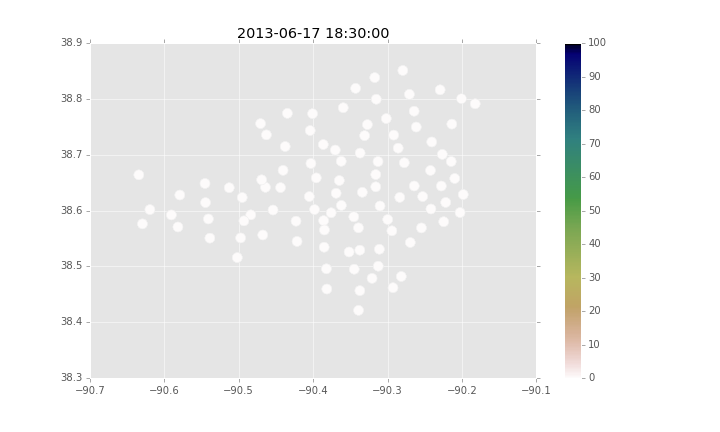
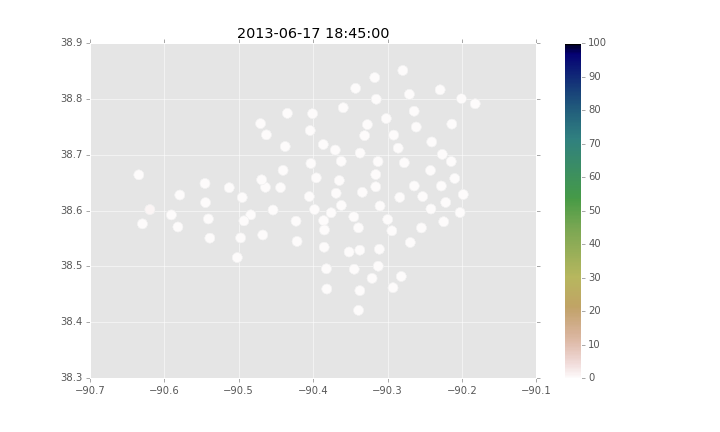
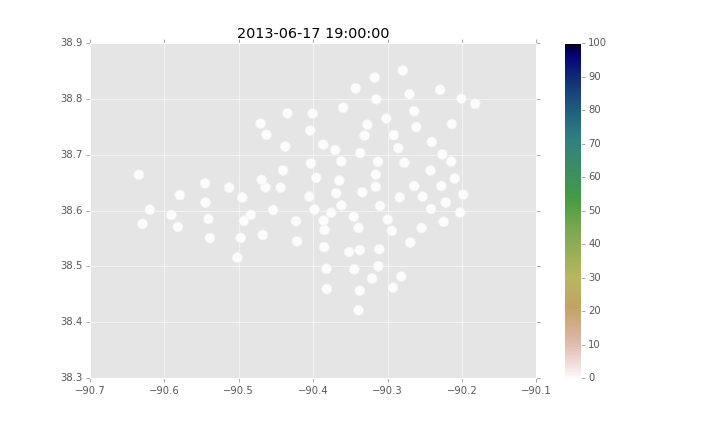
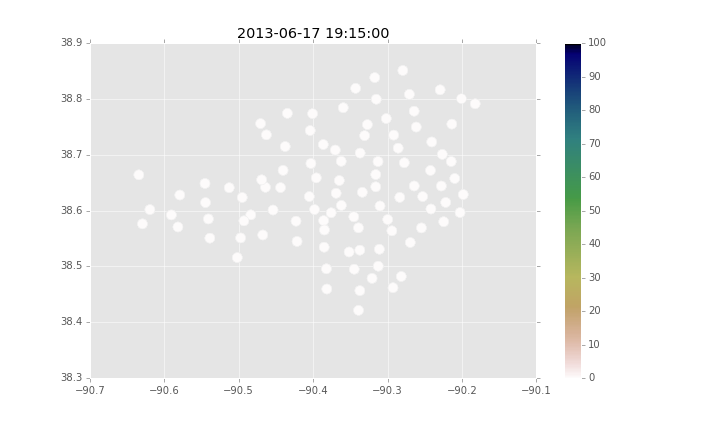
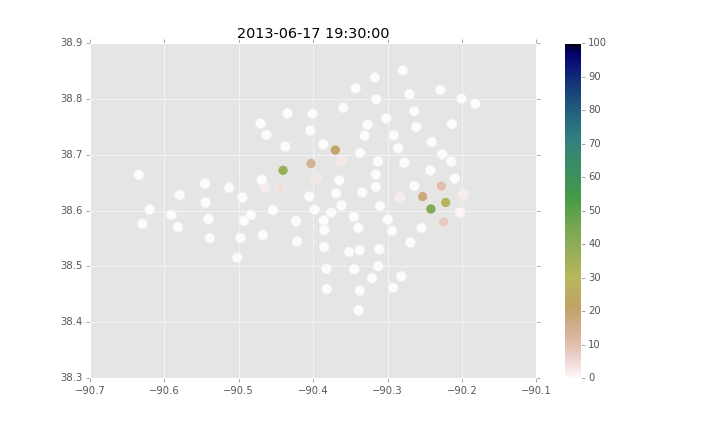
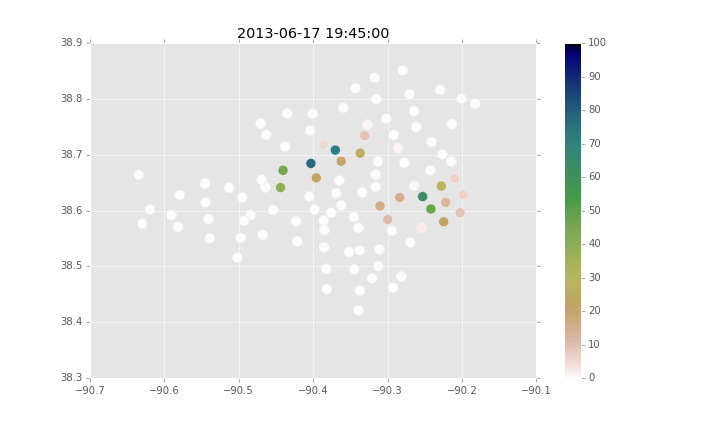
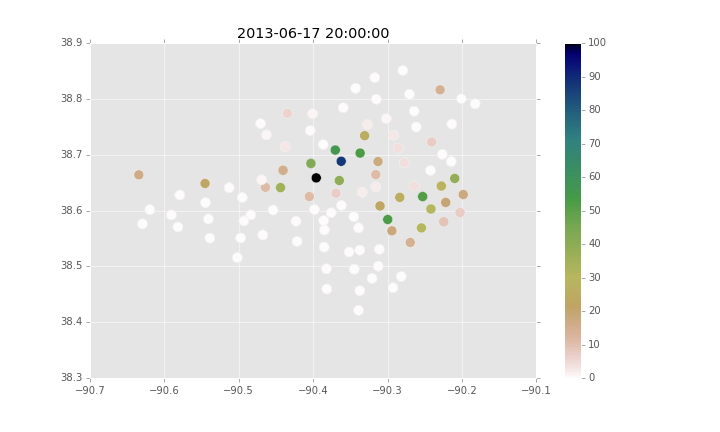
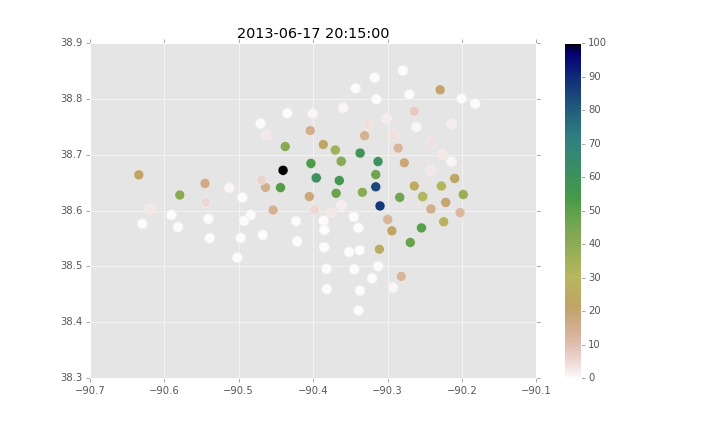
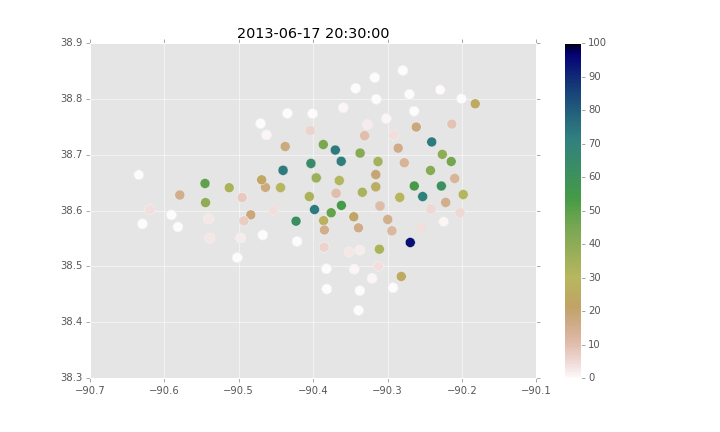
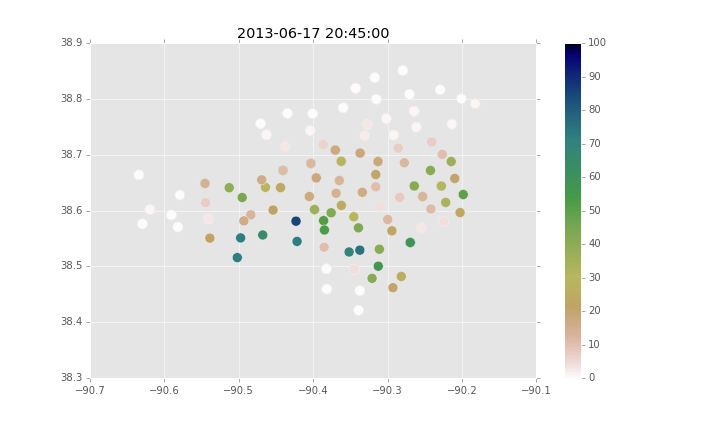
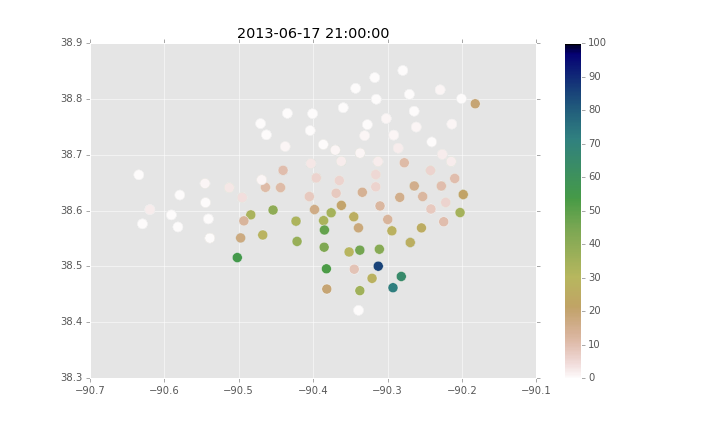
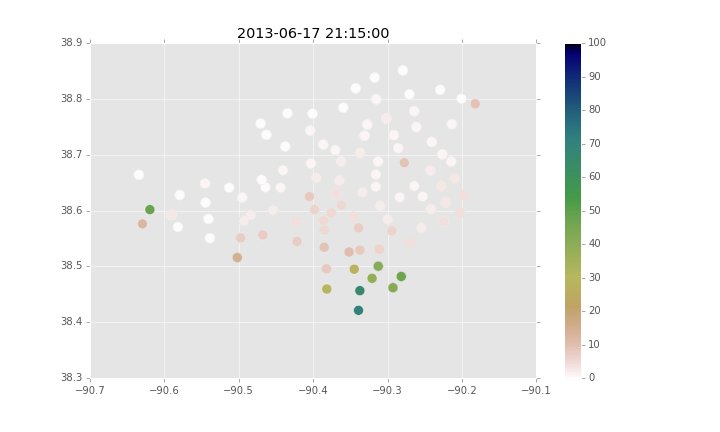
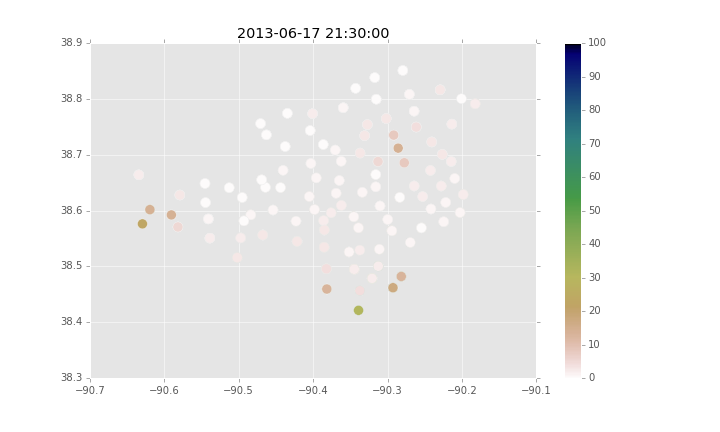
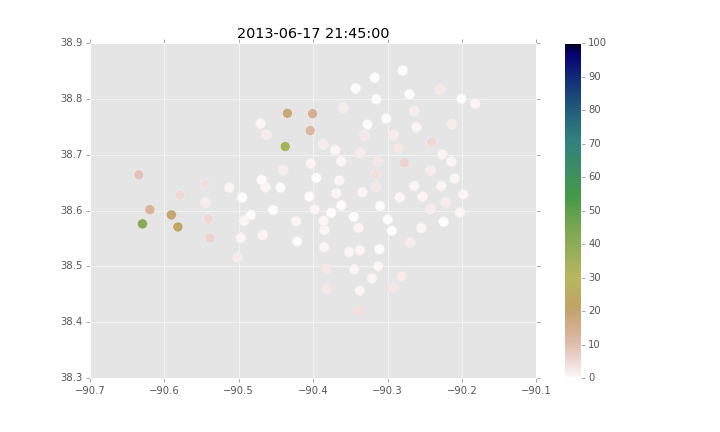
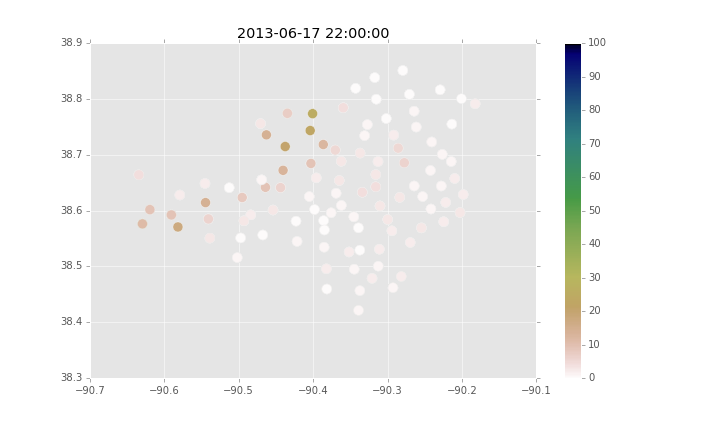
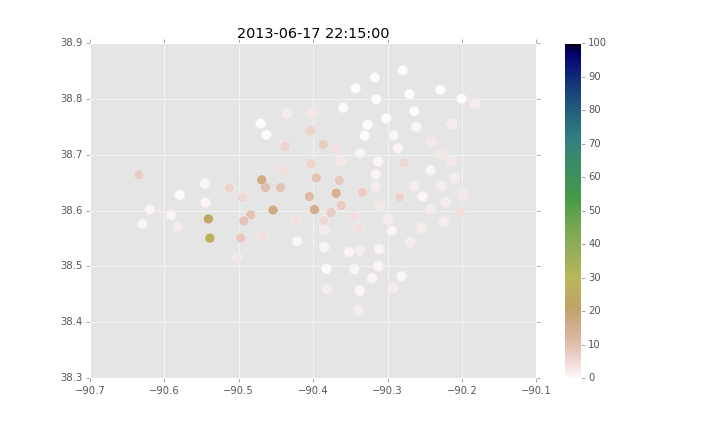
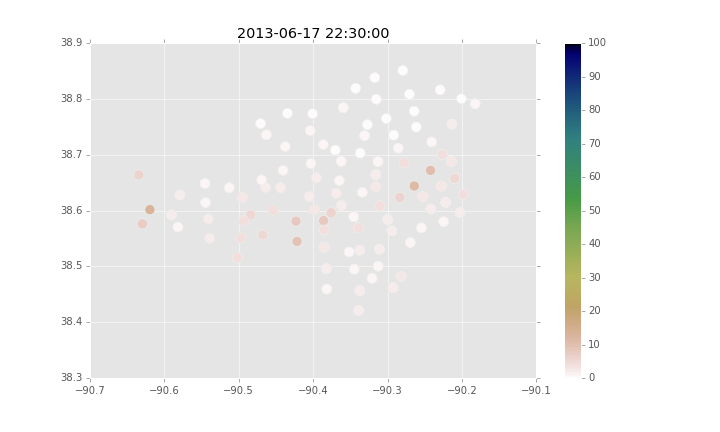
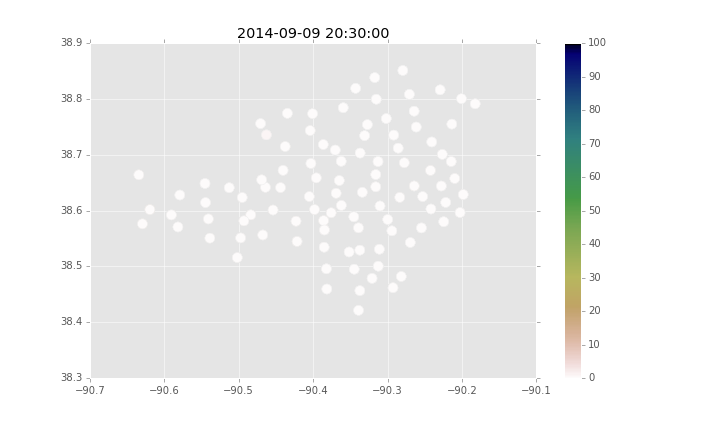
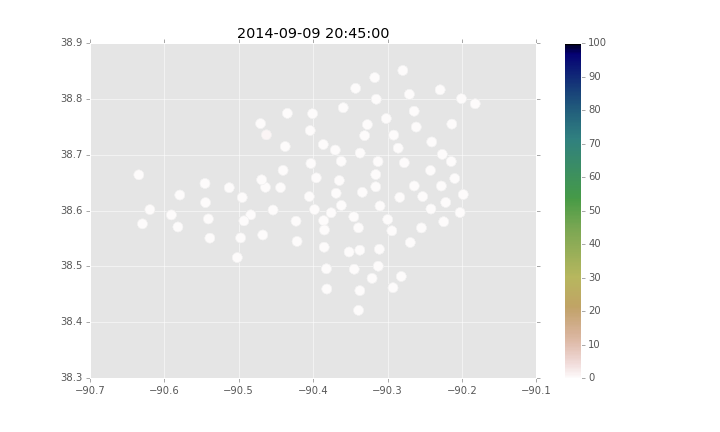
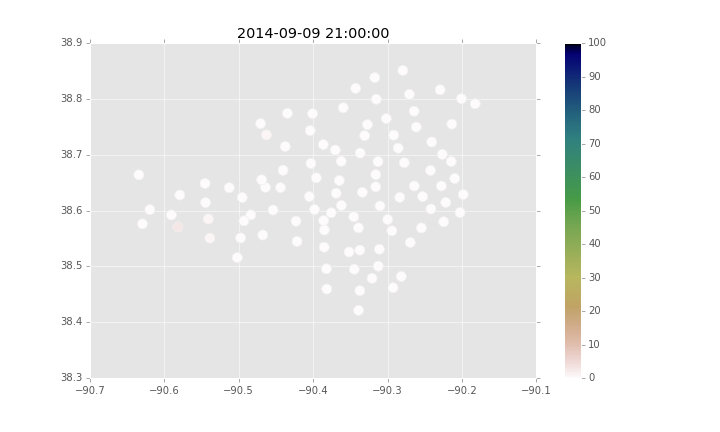
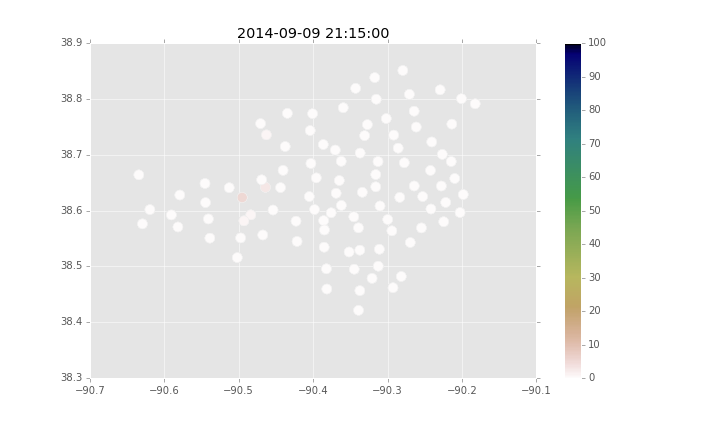
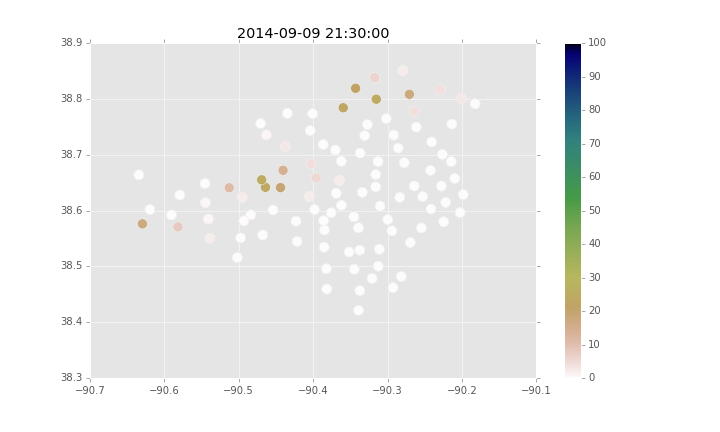
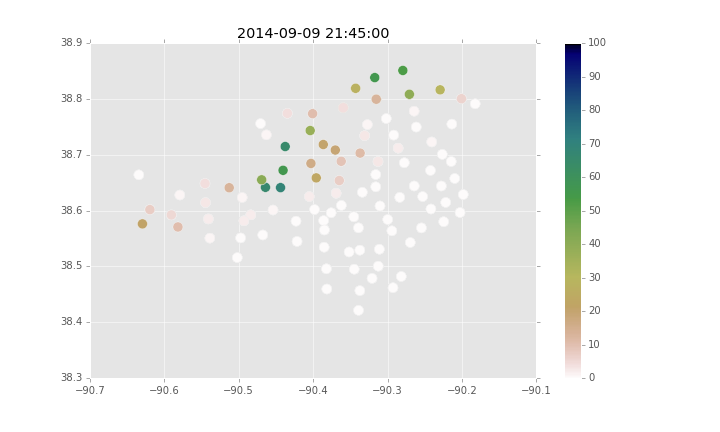
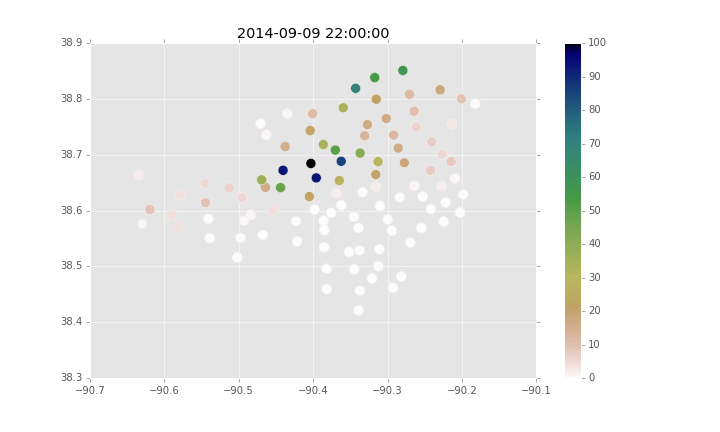
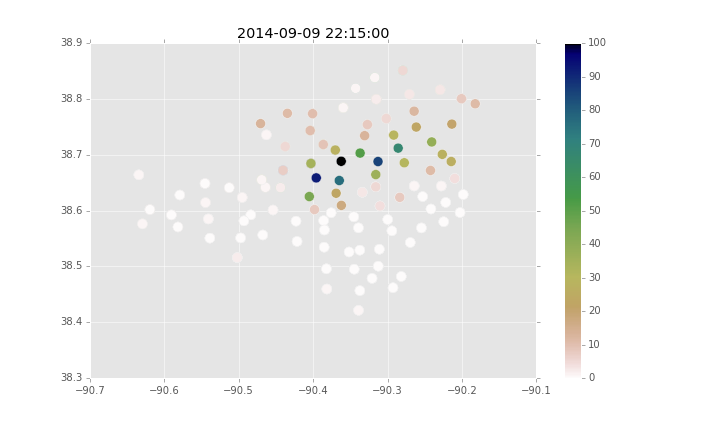
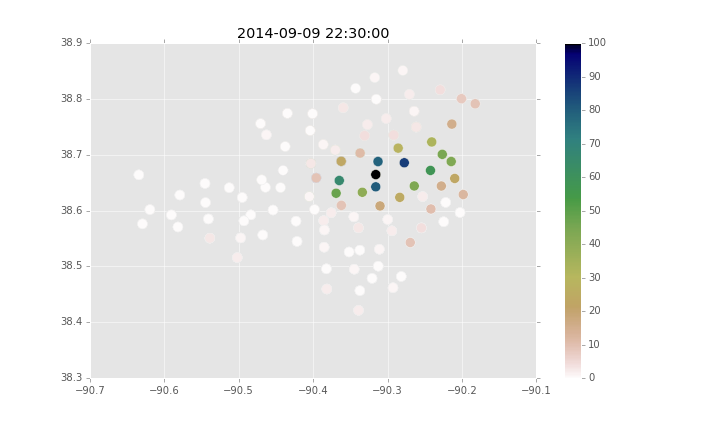
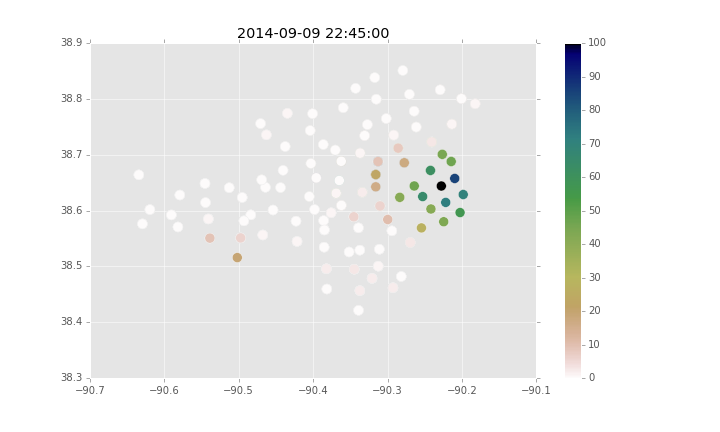
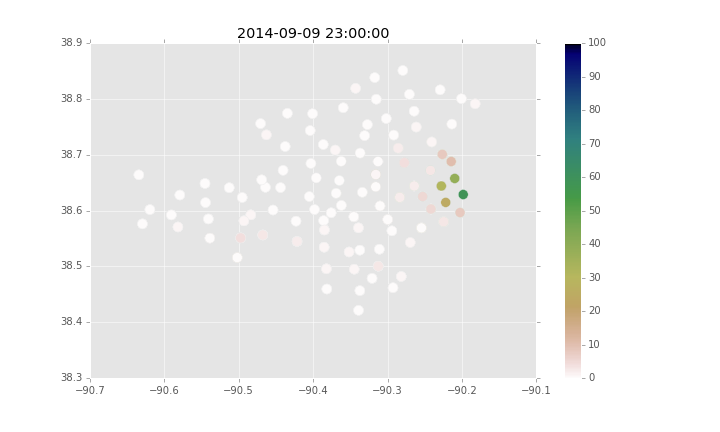
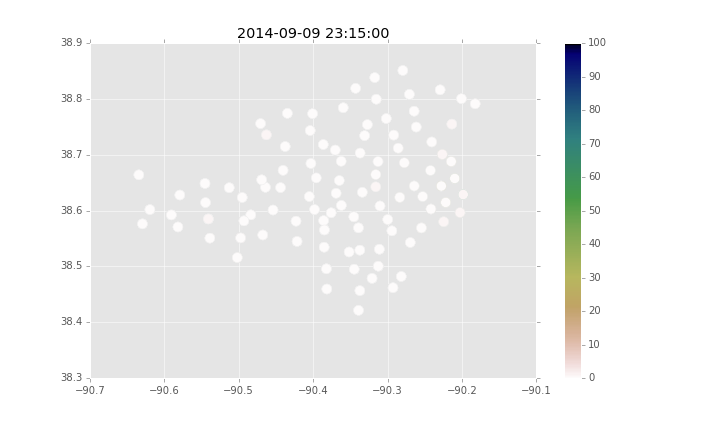
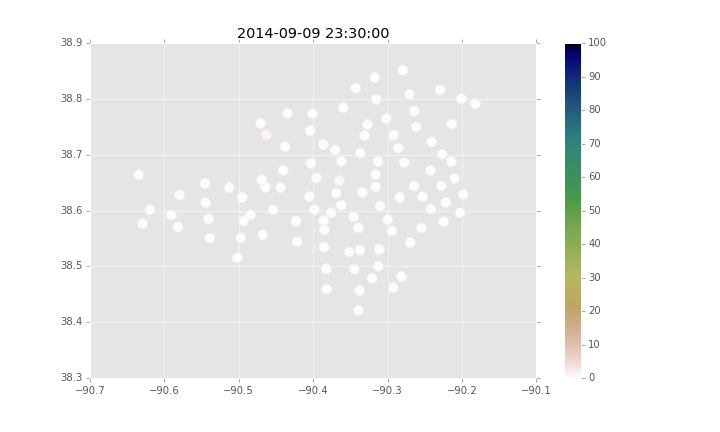
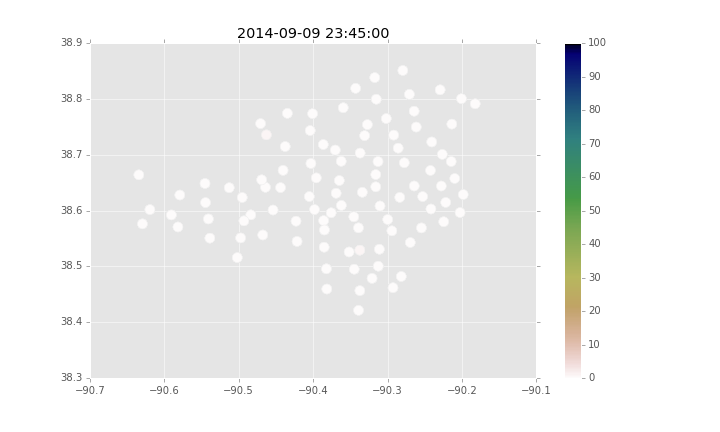
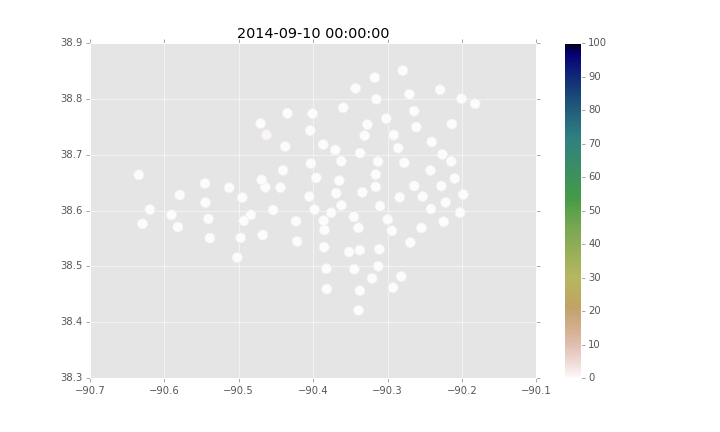
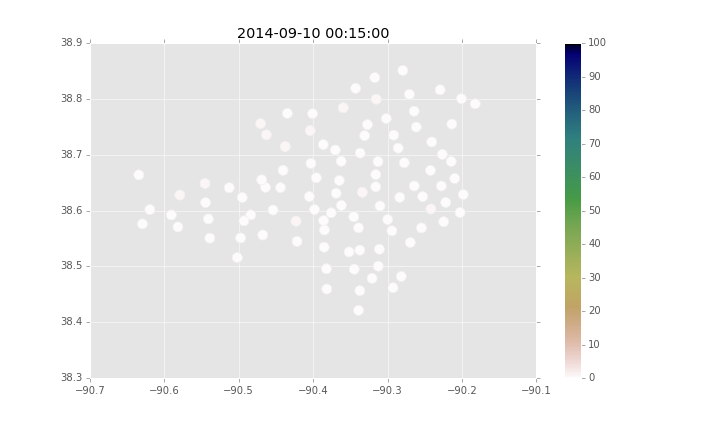
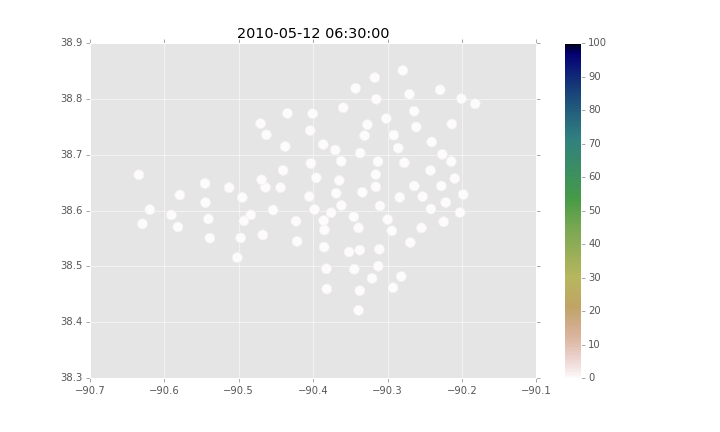
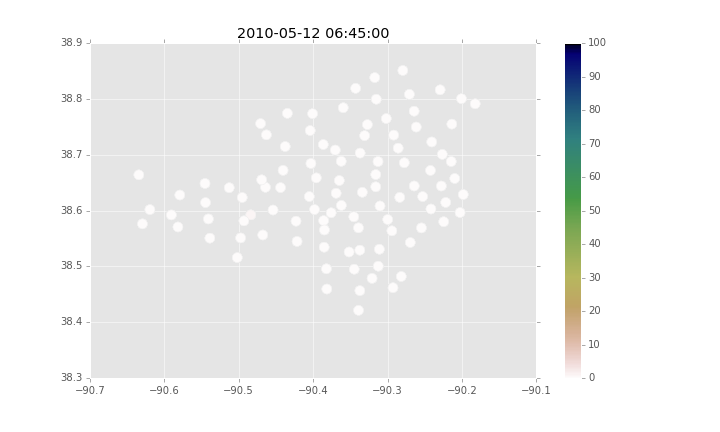
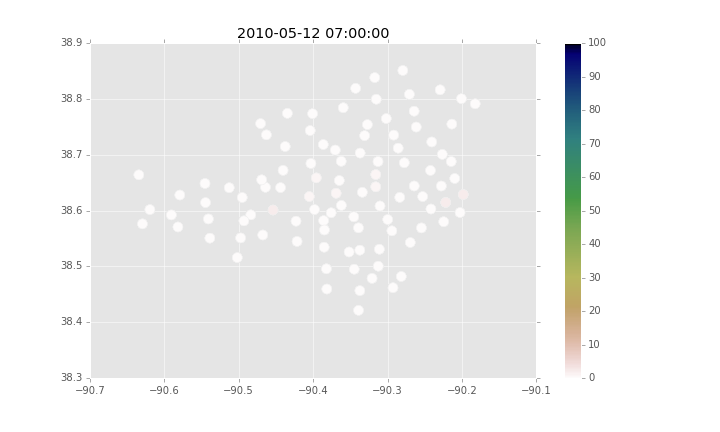
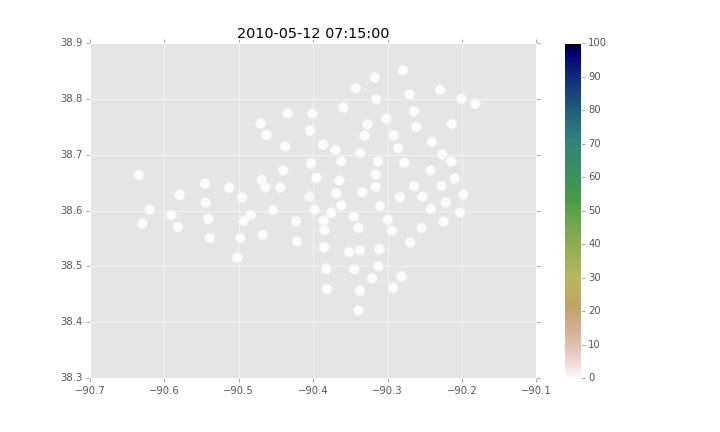
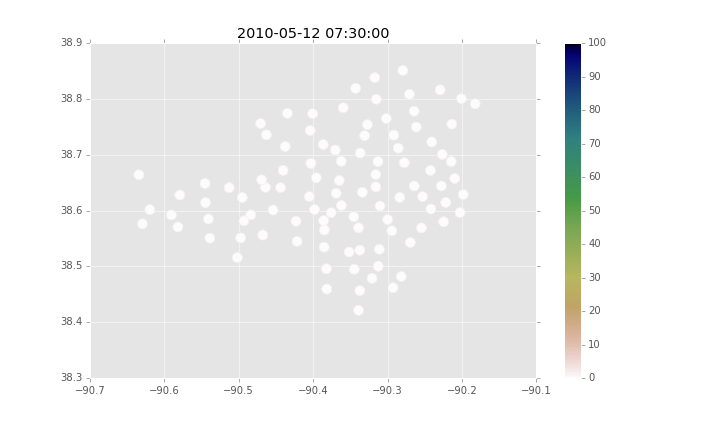
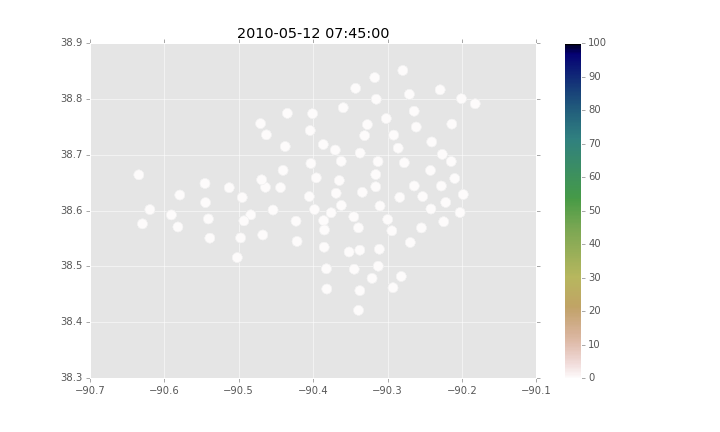
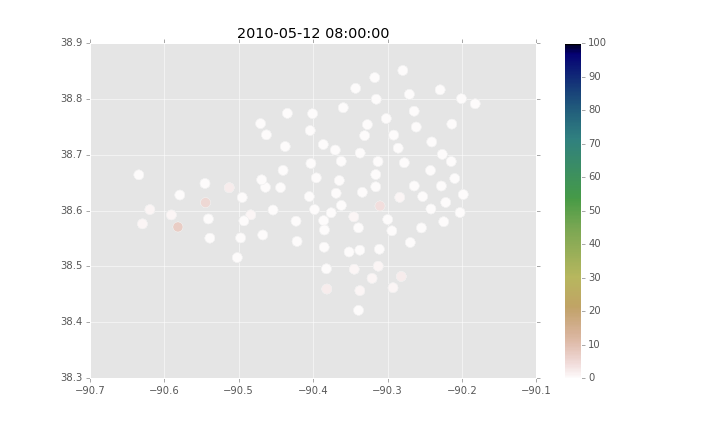
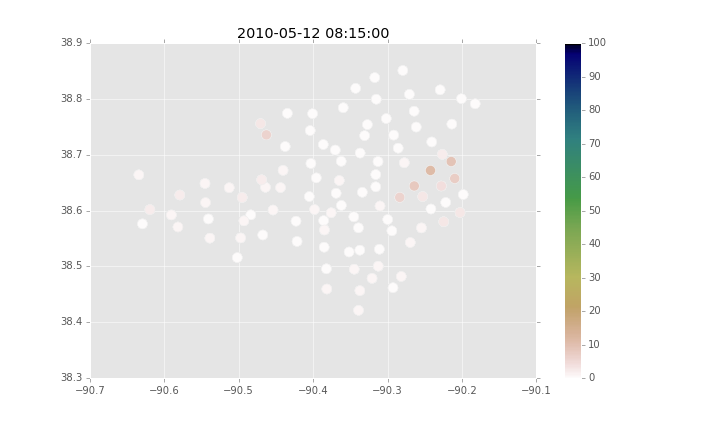
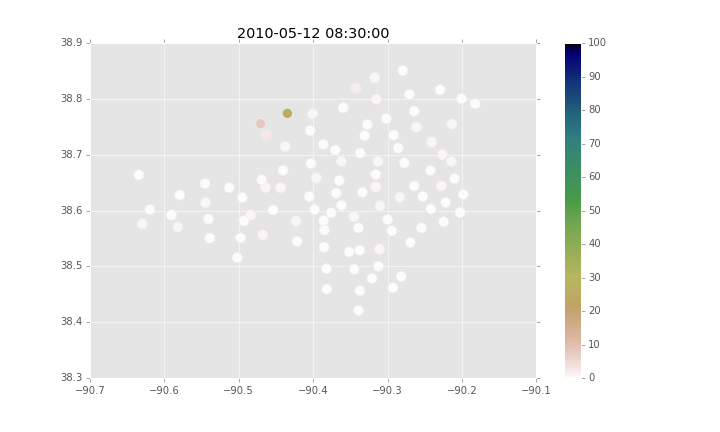
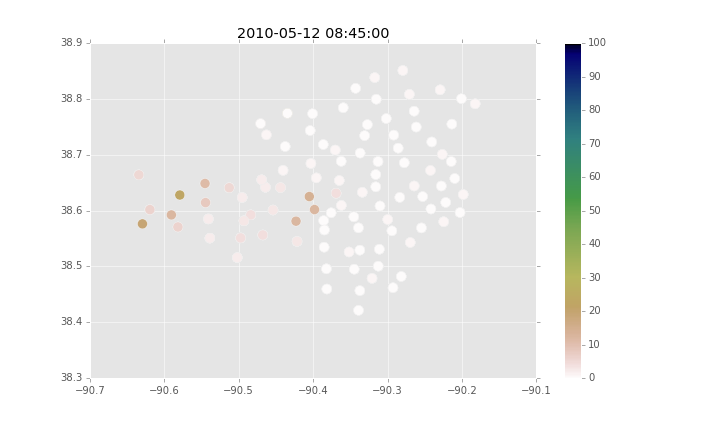
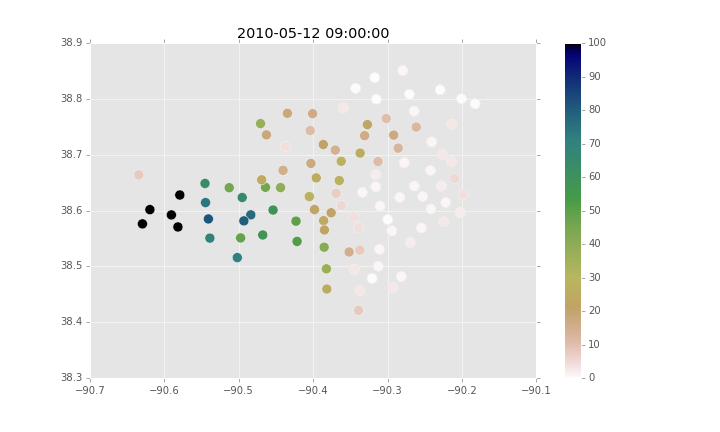
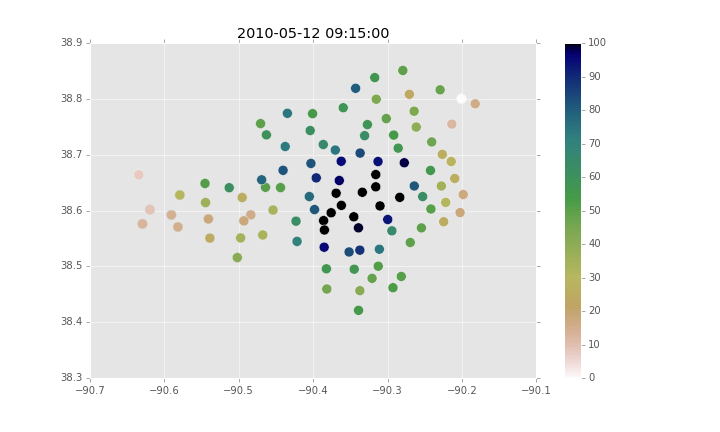
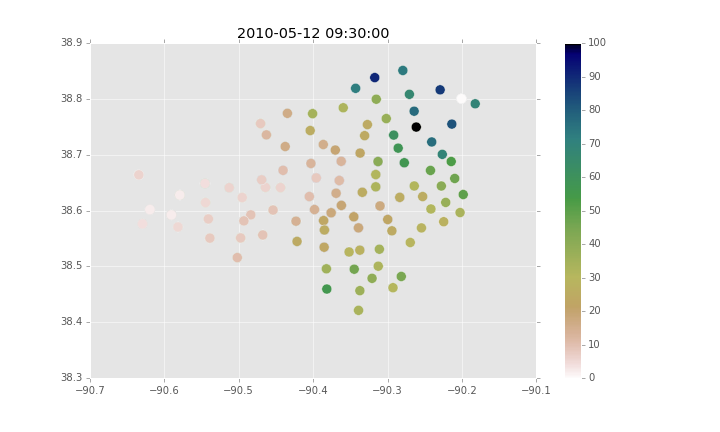
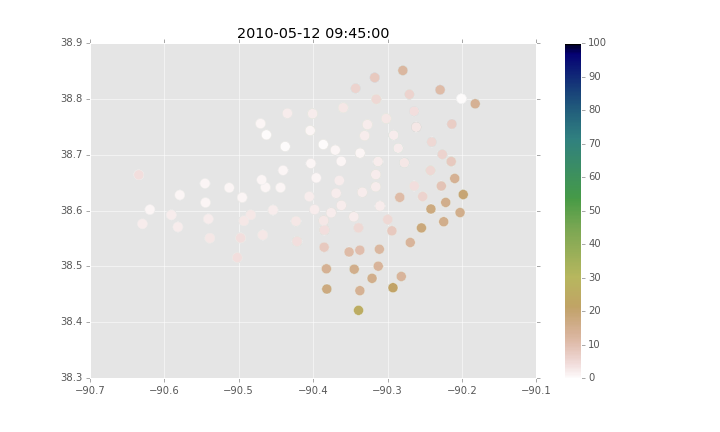
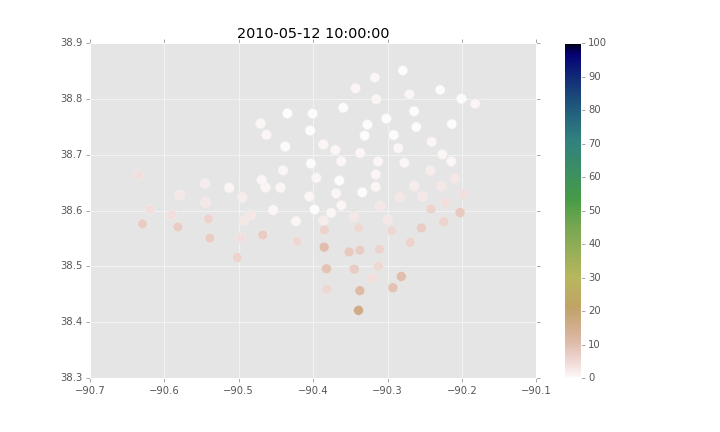
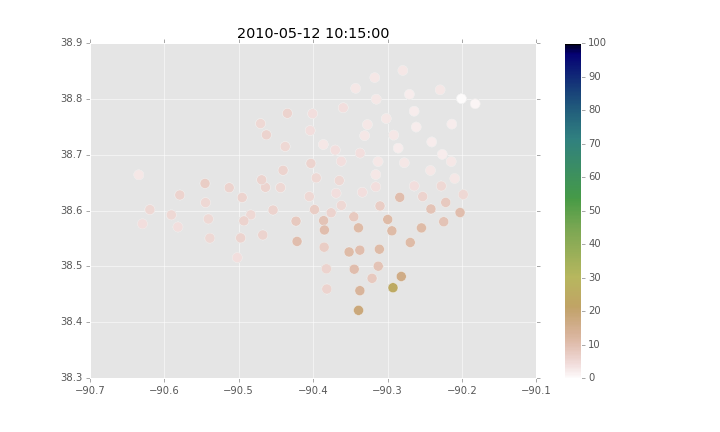

In [53]:
z.movie()

#### Make a movie of the actual Kriged values

[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]



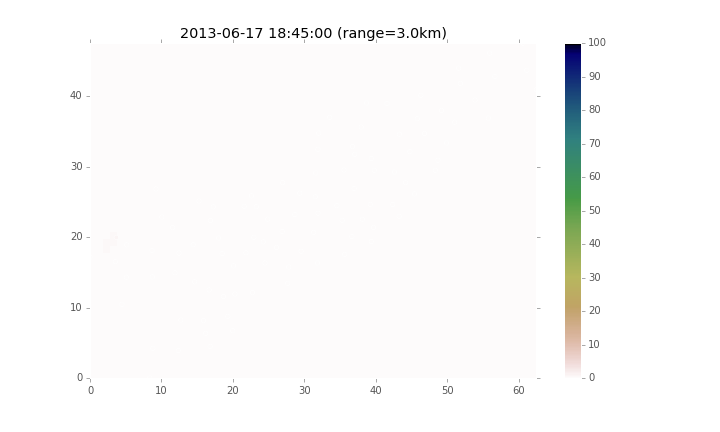
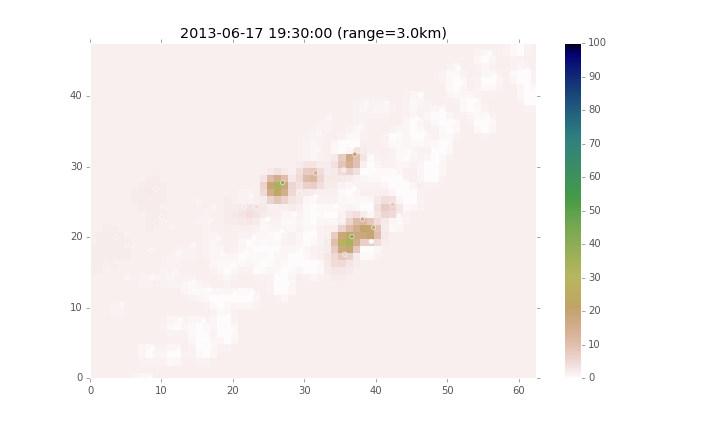
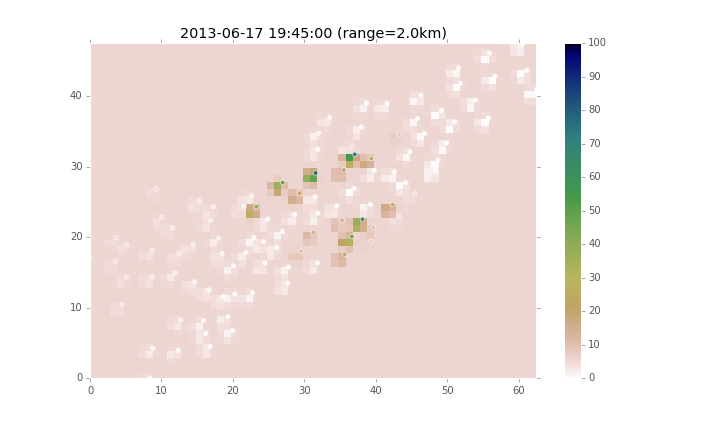
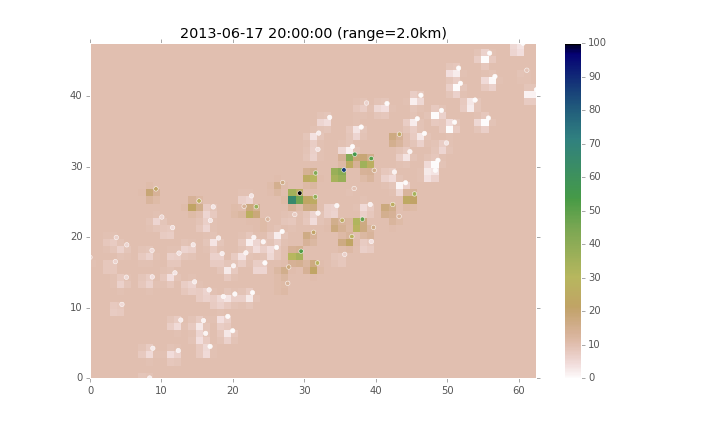
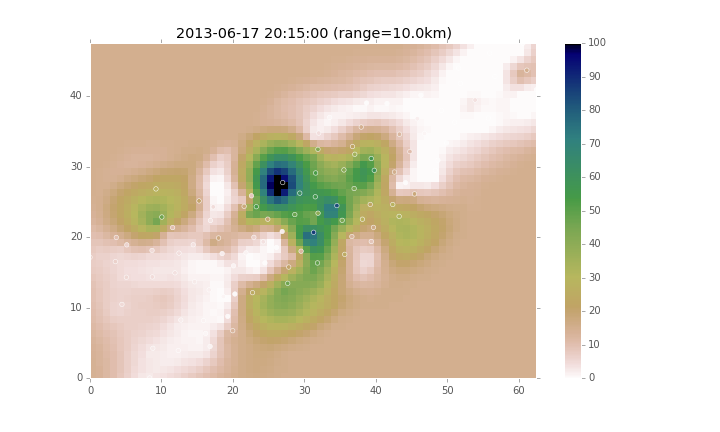
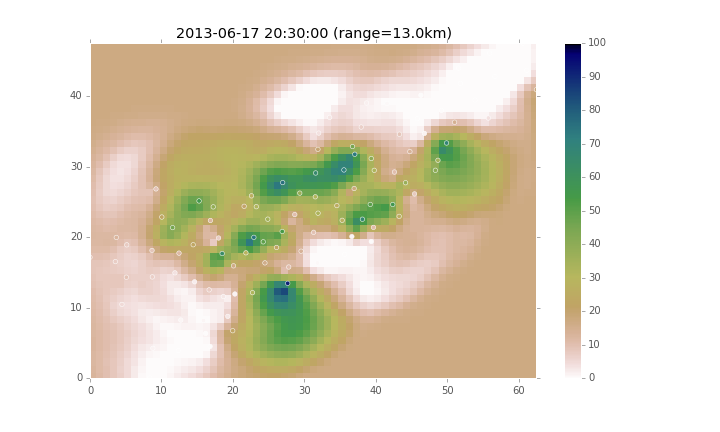
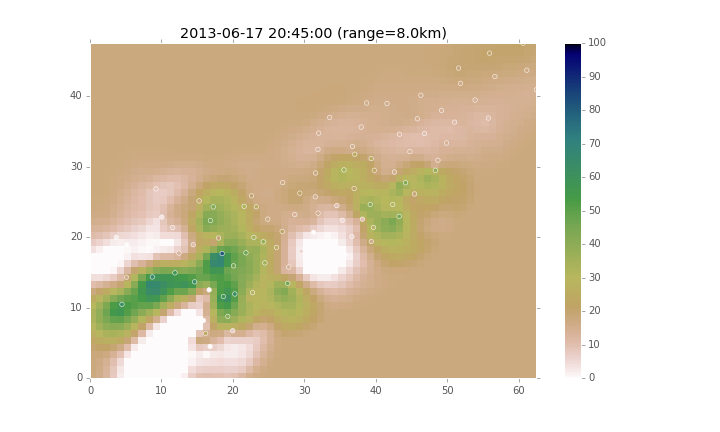
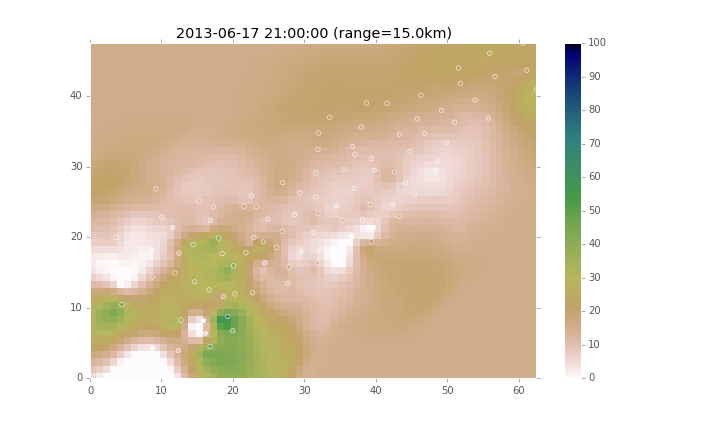
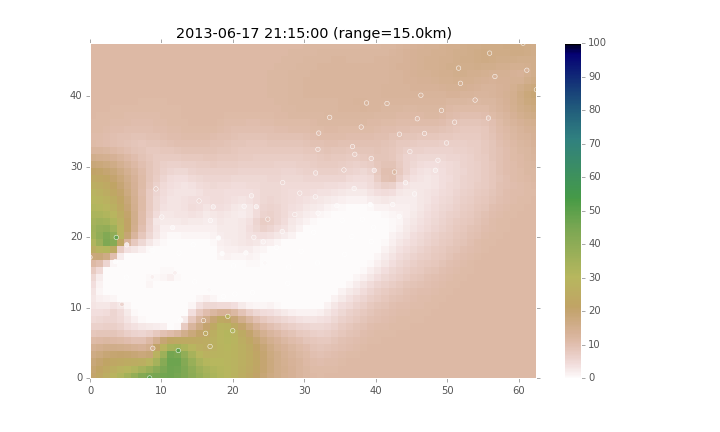
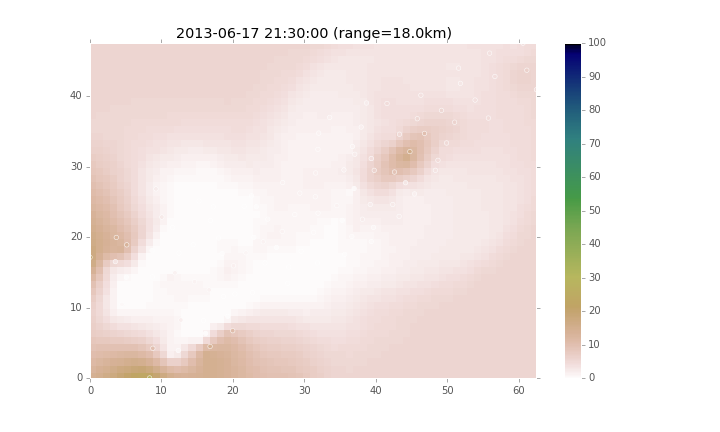
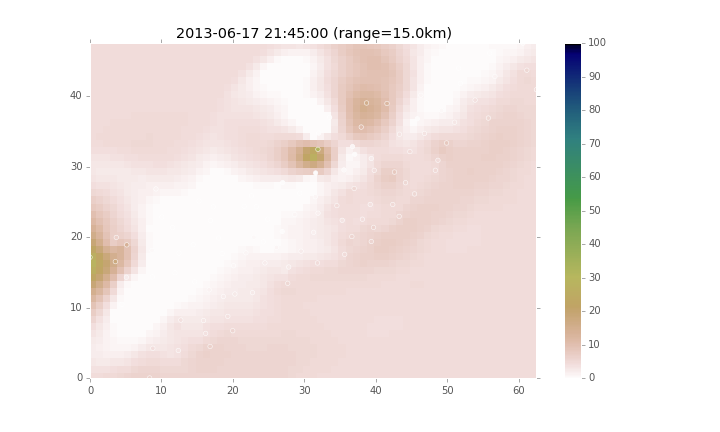
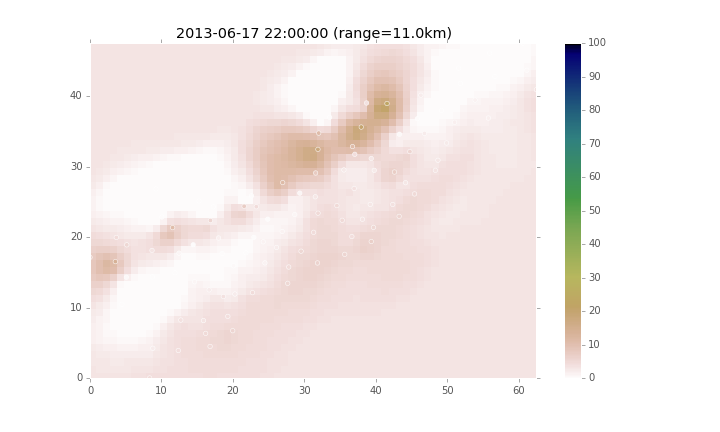
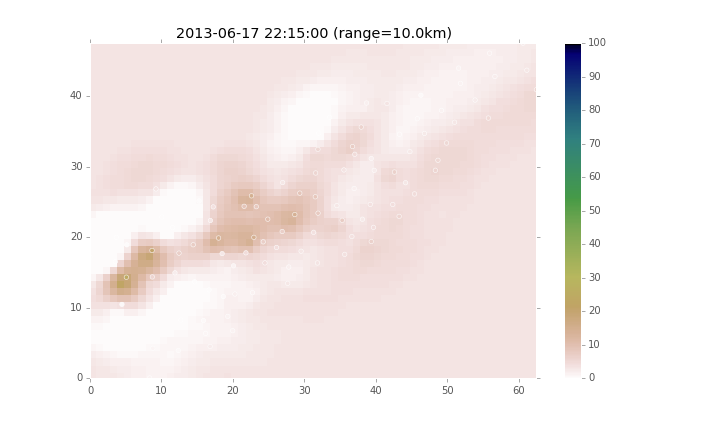
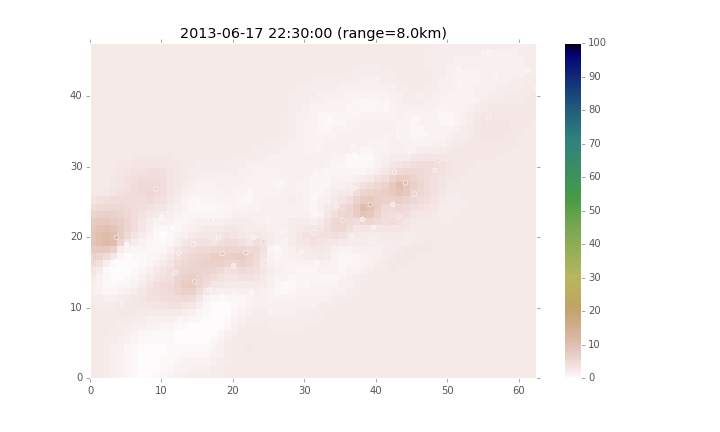
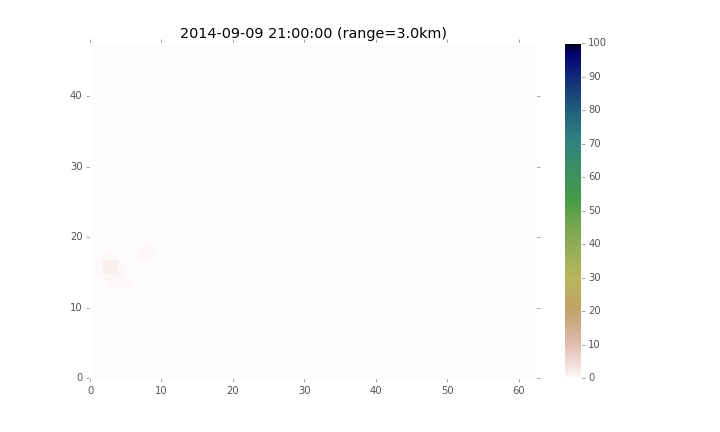
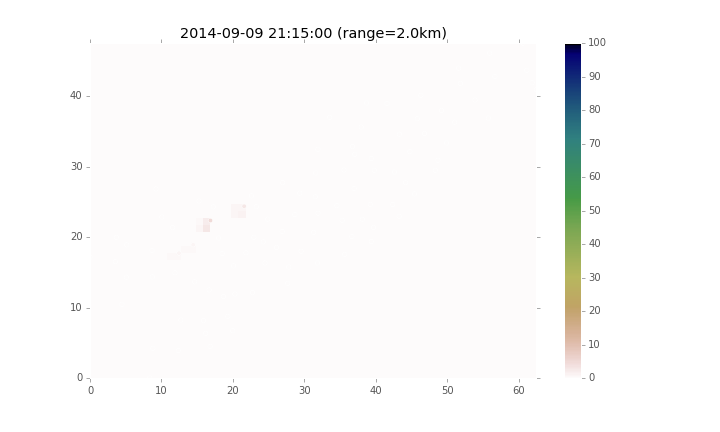
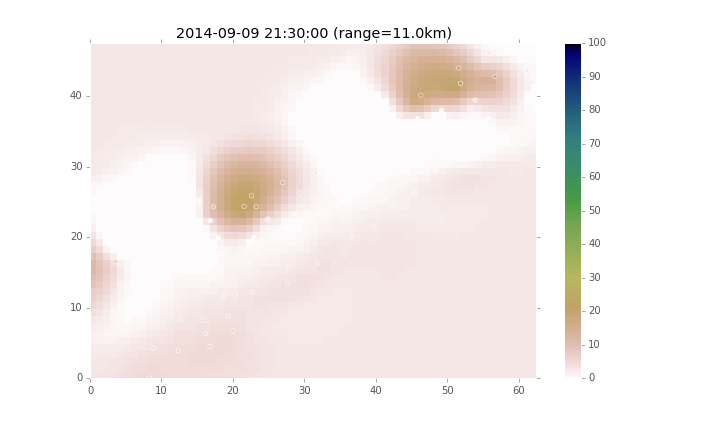
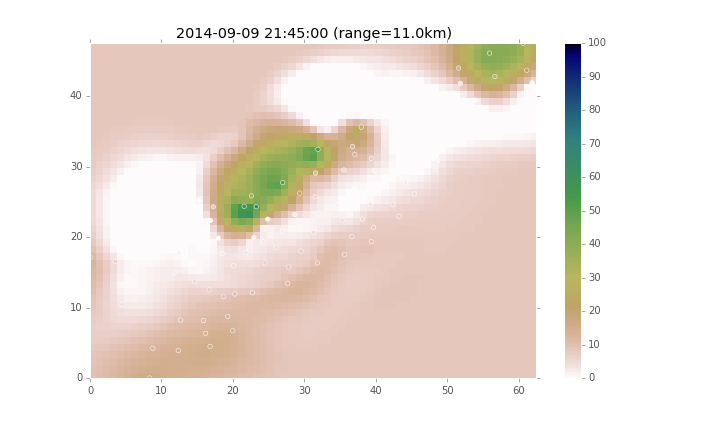
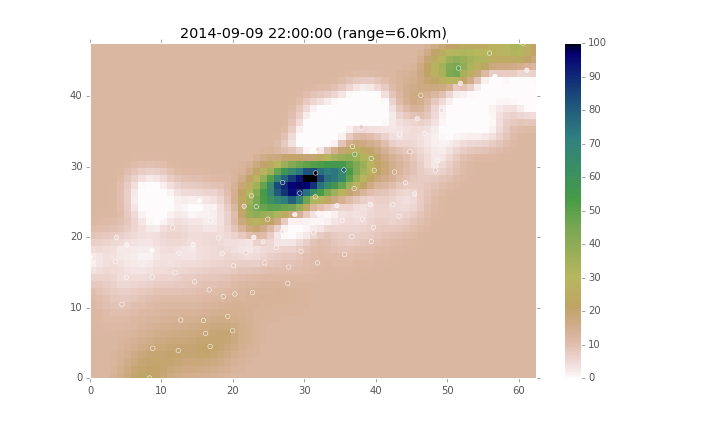
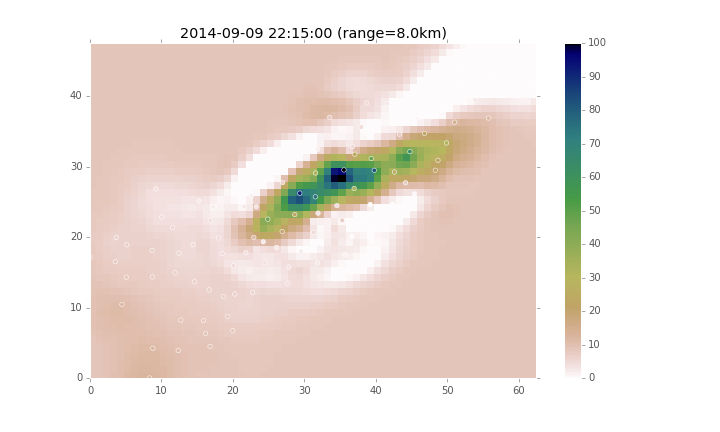
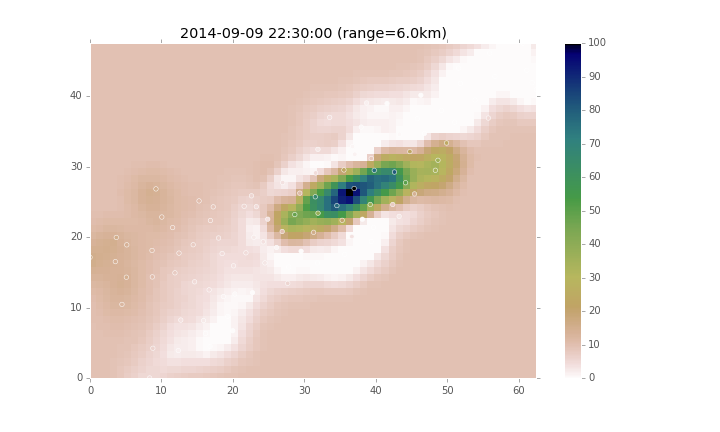
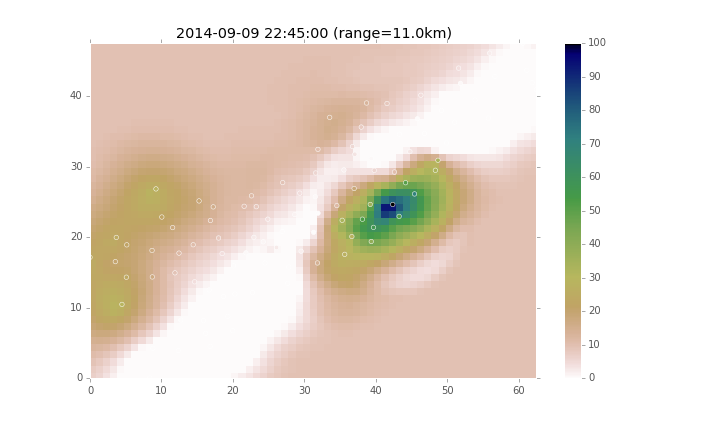
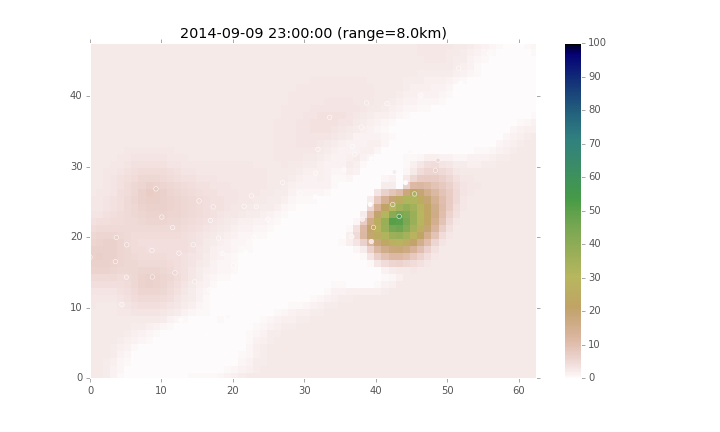
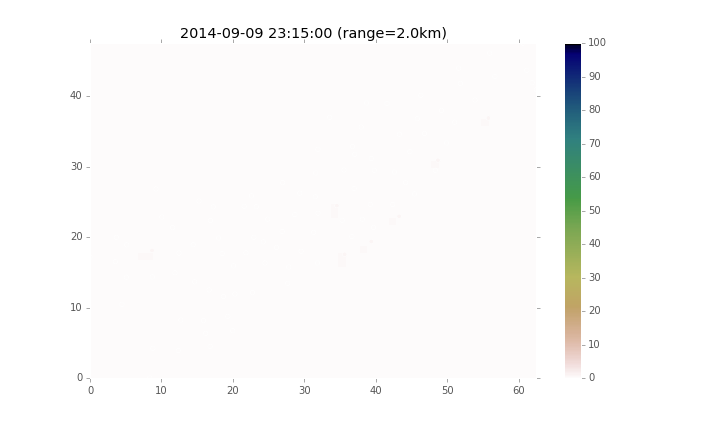
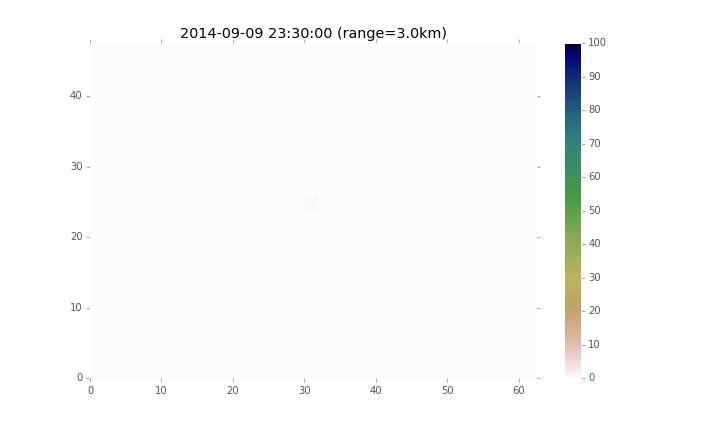
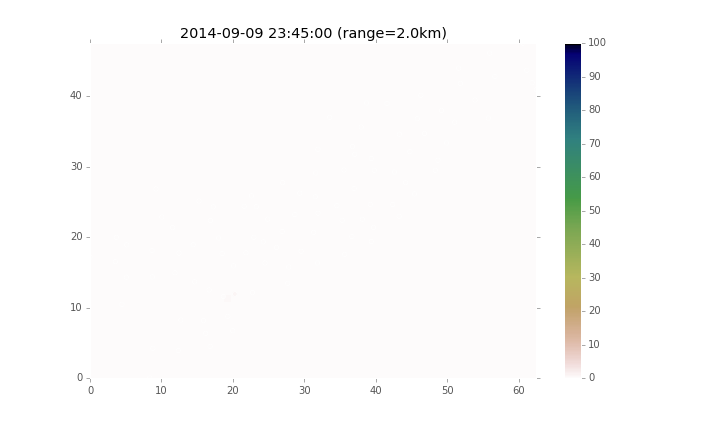
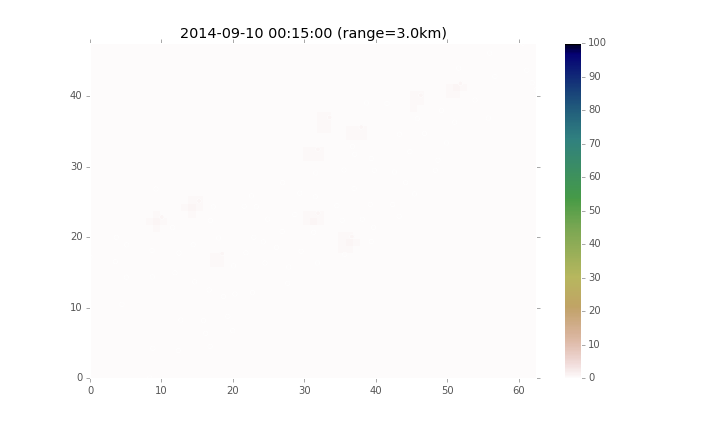
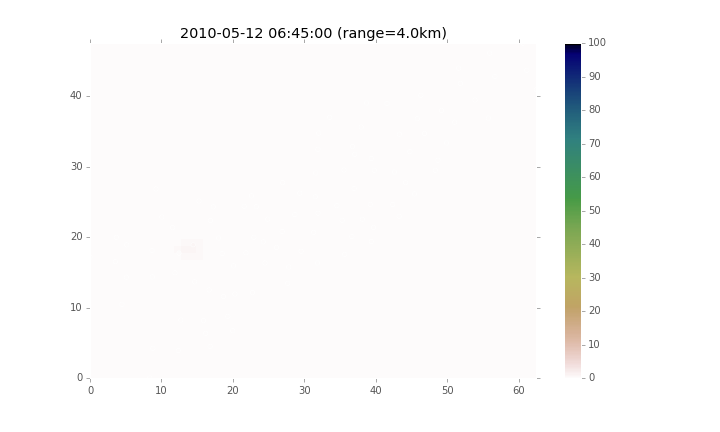
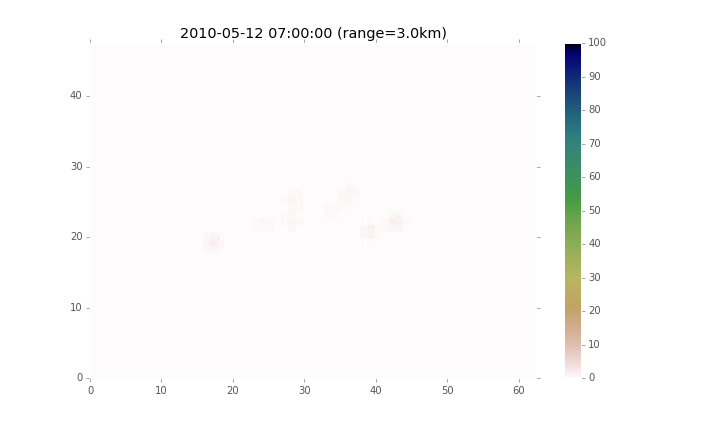
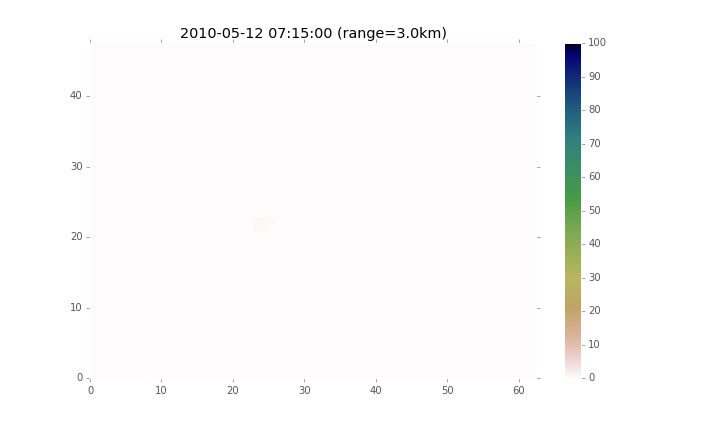
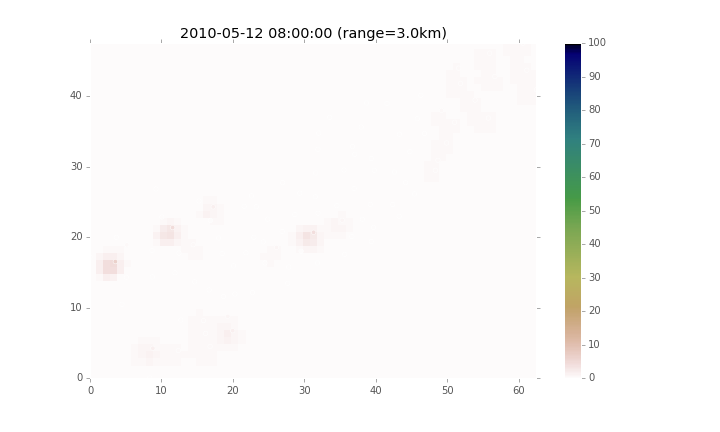
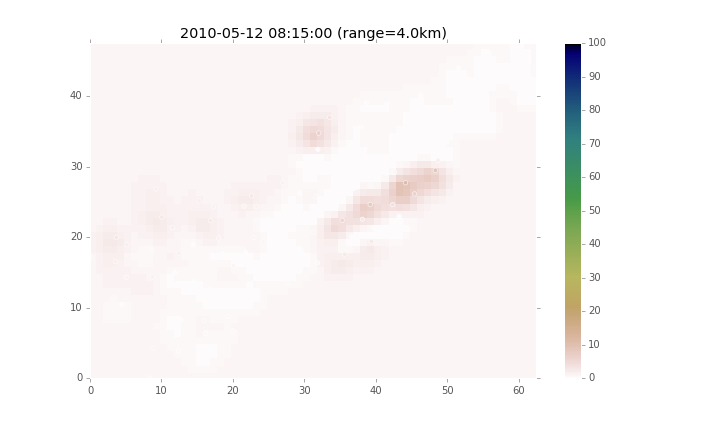
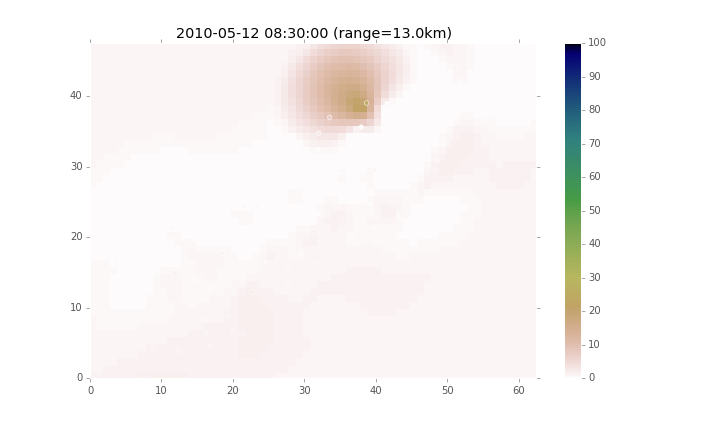
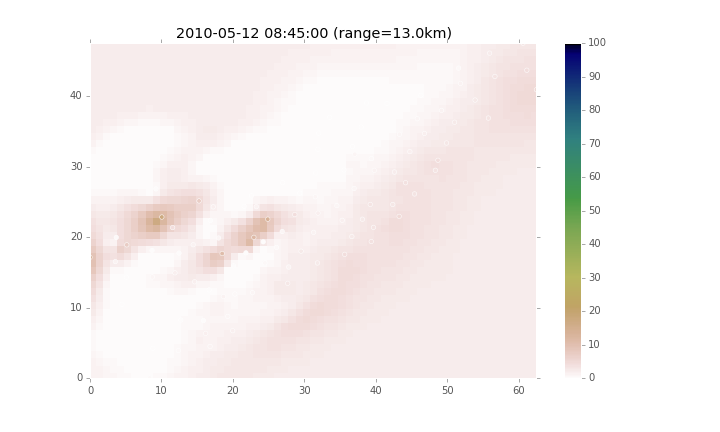
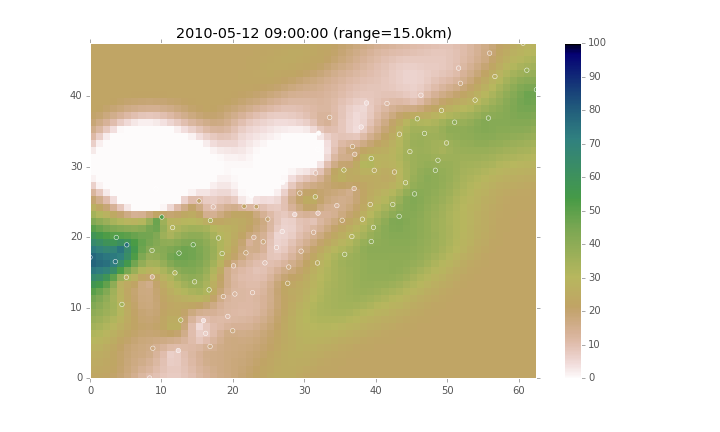
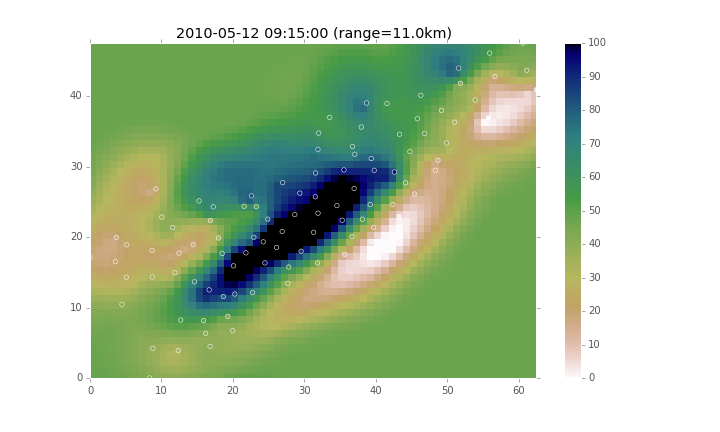
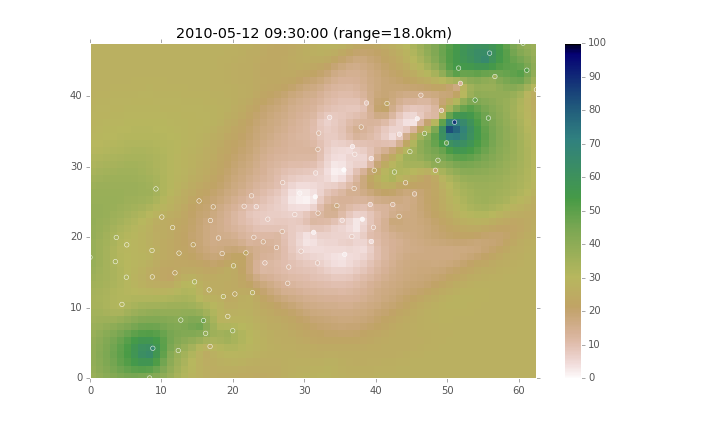
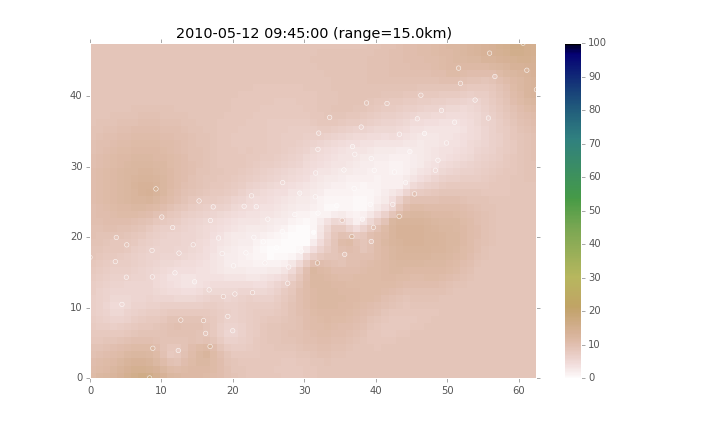
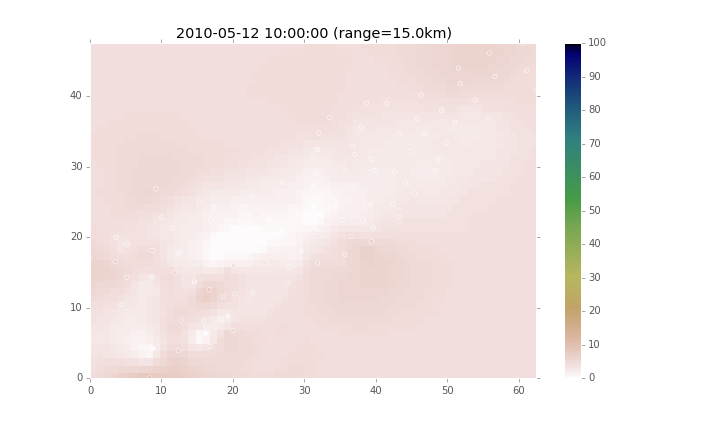
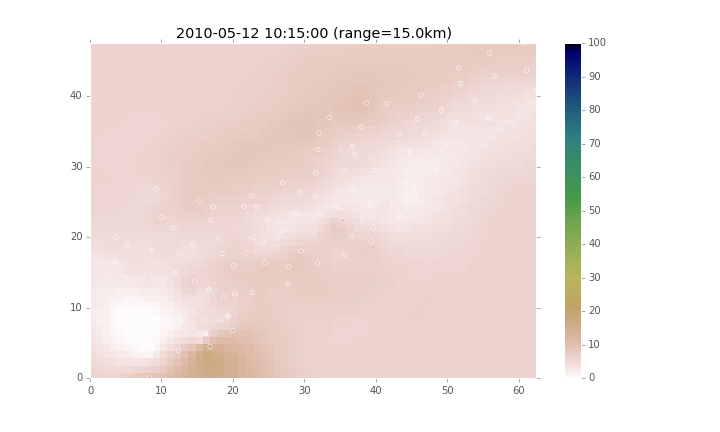

In [57]:
fig, ax = plt.subplots(1,1,figsize= (10,6))
sc = Event(res).krige(5, animated=True, ax=ax, vmin=0, vmax=100)
fig.colorbar(sc)

def animate(i):
    global res
    Event(res).krige(i+5, animated=True, ax=ax, vmin=0, vmax=100)
animation.FuncAnimation(fig, animate, frames=len(res.columns[5:]), interval=300, blit=True)

[using ordinary kriging]


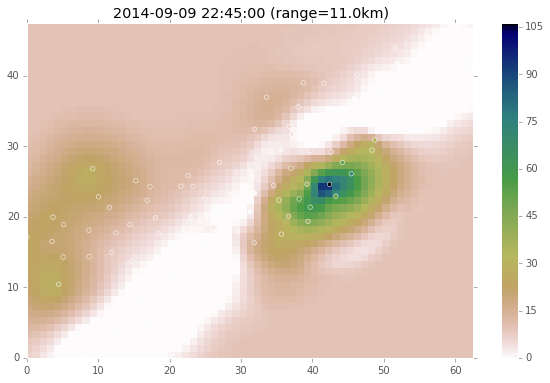

In [94]:
e = Event(res)
i = e.df.columns.get_loc(pd.Timestamp('2014-09-09 22:45:00'))
k = e.krige(i=i, animated=False)
plt.savefig(p.save_path + 'Kriged Rain Rate for 2014-09-09 22:45.jpg')